In [83]:
# importing modules
import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256, Inferno256, Magma256
from bokeh.palettes import BrBG, PiYG, RdGy, RdYlGn, YlGnBu
from bokeh.models import LinearColorMapper, ColorBar

In [84]:
# Read the data and merge district level files
rheas_district= pd.read_csv('data/rheas/zambia_rheas_district_data_clean.csv')
preharvest_district=pd.read_csv('data/preharvest/preharvest_cleaned.csv')

# rename district columns
rheas_district.rename(columns={'district':'district_b'},inplace=True)
preharvest_district.rename(columns={'district':'district_b'},inplace=True)

# reas district shapefile
district_shp=gpd.read_file('data/shp/zmb_district_cleaned.shp')


In [85]:
# aggregate district level to one per district
rheas_district_grouped_grouped=rheas_district.groupby('district_b', as_index=False).agg({'yield':'mean'})
preharvest_district_grouped=preharvest_district.groupby('district_b', as_index=False).agg({'yield':'mean'})
# read rheas_preharvest_district_metrics
rheas_preharvest_district_metrics=pd.read_csv('data/metrics/preharvest_rheas_district_metrics.csv')

# rename preharvest yield column before merging
preharvest_district_grouped.rename(columns={'yield':'preharvest_yield', 'district_b':'district_p'}, inplace=True)

In [86]:
# extract rheas for the districts merging preharvest
preharvest_districts=list(preharvest_district_grouped.district_p.unique())
rheas_districts=list(rheas_district_grouped_grouped.district_b.unique())

list_rheas=[]

for district in rheas_districts:
    if district not in preharvest_districts:
        pass
    else:
        df_rheas=rheas_district_grouped_grouped.loc[rheas_district_grouped_grouped['district_b']==district]
        list_rheas.append(df_rheas)
rheas_district_grouped_grouped1=pd.concat(list_rheas, ignore_index=True)

In [87]:
# merge rheas, preharvest and metrics
# sort metrics data first
rheas_preharvest_district_metrics.sort_values(by='district',ignore_index=True,inplace=True)
# rheas_district_grouped_grouped1
# preharvest_district_grouped
# rheas_preharvest_district_metrics
rheas_metrics=pd.concat([rheas_district_grouped_grouped1,preharvest_district_grouped,
                                     rheas_preharvest_district_metrics], axis=1)

In [88]:
# drop columns
rheas_metrics.drop(['district_p','district'], axis=1, inplace=True)
rheas_metrics['yield_corrected']=rheas_metrics['yield']-rheas_metrics['bias']
rheas_metrics

,district_b,yield,preharvest_yield,correlation,rmse,ubrmse,bias,yield_corrected
0,chadiza,4.002790,2.510959,0.330071,1.497654,0.337190,1.459202,2.543588
1,chama,4.021222,2.639932,0.044019,1.443173,0.524625,1.344439,2.676784
2,chavuma,4.022218,2.662906,0.082378,1.428006,0.531392,1.325453,2.696765
3,chibombo,4.009595,2.541407,0.332879,1.466129,0.319028,1.430998,2.578597
4,chiengi,4.017078,2.605939,-0.036587,1.423604,0.369104,1.374922,2.642156
...,...,...,...,...,...,...,...,...
69,shangombo,4.021398,0.992796,0.265701,3.011464,0.319386,2.994480,1.026918
70,siavonga,4.015350,1.806810,0.570296,2.199657,0.379953,2.166594,1.848756
71,sinazongwe,3.997217,1.665775,0.283374,2.335273,0.457446,2.290031,1.707186
72,solwezi,4.004949,2.094350,-0.598471,1.942293,0.466634,1.885405,2.119543


In [89]:
# save to csv
rheas_metrics.to_csv('data/rheas/rheas_preharvest_district_corrected.csv', index=False)

In [90]:
# Read the rheas and preharvest data and  province level files
# district_shp

rheas_province=pd.read_csv('data/rheas/zambia_rheas_province_data_clean.csv')
preharvest_province=pd.read_csv('data/preharvest/zambia_preharvest_province_data_clean.csv')
rheas_pre_prov_metrics=pd.read_csv('data/metrics/preharvest_rheas_province_level_metrics.csv')

In [91]:
# select rheas for the year 2011 to 2022
years=list(preharvest_province.year.unique())
years_list2=[]
for y in years:
    rh2=rheas_province.loc[rheas_province['year']==y]
    years_list2.append(rh2)
    rh3=pd.concat(years_list2,ignore_index=True)

In [92]:
# aggregate over provinces
rheas3=rh3.groupby(['province_b'],as_index=False).agg({'yield':'mean'})
preharvest3=preharvest_province.groupby(['province_b'],as_index=False).agg({'yield':'mean'})

# sort 
rheas_pre_prov_metrics.sort_values('province',ignore_index=True,inplace=True)
rheas3.sort_values('province_b',ignore_index=True,inplace=True)
preharvest3.sort_values('province_b',ignore_index=True,inplace=True)

# rename yield for preharvest
preharvest3.rename(columns={'yield':'preharvest_yield','province_b':'province_p'},inplace=True)

# concatenate 
rheas_pre_prov_corrected=pd.concat([rheas3,preharvest3,rheas_pre_prov_metrics],axis=1)

rheas_pre_prov_corrected['yield_corrected']=rheas_pre_prov_corrected[
    'yield']/rheas_pre_prov_corrected['bias']

C:\Users\kasit\AppData\Local\Temp\ipykernel_12216\3071628862.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  rheas_pre_prov_shp.to_file('data/shp/rheas_prehavest_province.shp',index=False)


ValueError: 'BrB' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

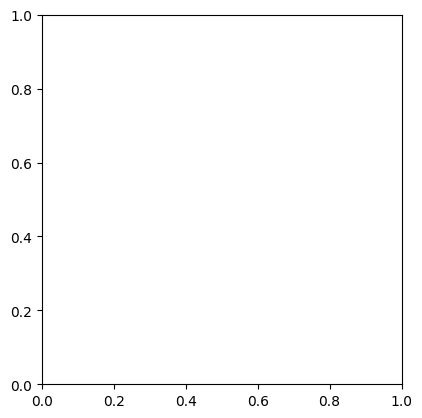

In [93]:
# drop unnecesary columns
rheas_pre_prov_corrected.drop(columns={'province_p','province'},inplace=True)

# save
rheas_pre_prov_corrected.to_csv('data/rheas/rheas_preharvest_prov_corrected.csv')
# merge to a shapefile
province_shp=gpd.read_file('data/shp/zmb_province_cleaned.shp')
# rename province_b to province
# rheas_pre_prov_corrected.rename(columns={'province_b':'province'}, inplace=True)
# merge
rheas_pre_prov_shp=pd.merge(province_shp,rheas_pre_prov_corrected, on='province_b')
# save shapefile
rheas_pre_prov_shp.to_file('data/shp/rheas_prehavest_province.shp',index=False)
rheas_pre_prov_shp.plot('yield', cmap='BrB')

In [13]:
# province level rheas and postprovince
# read data
province_shp
rheas_post_province_metrics=pd.read_csv('data/metrics/postharvest_rheas_province_level_metrics.csv')
postharvest_province=pd.read_csv('data/postharvest/zambia_postharvest_province_data_clean.csv')
preharvest_province=pd.read_csv('data/preharvest/zambia_preharvest_province_data_clean.csv')

In [14]:
# select data for 2011 to 2014
years=list(postharvest_province.year.unique())
years_list3=[]
years_list4=[]
years_list5=[]
for y in years:
    rh4=rheas_province.loc[rheas_province['year']==y]
    pre4=preharvest_province.loc[preharvest_province['year']==y]
    years_list3.append(rh4)
    years_list4.append(pre4)
    rh5=pd.concat(years_list3,ignore_index=True)
    pre5=pd.concat(years_list4,ignore_index=True)
    
preharvest_province=pre5
rheas_province=rh5

In [15]:
# aggregate over provinces
rheas_province2=rheas_province.groupby(['province_b'],as_index=False).agg({'yield':'mean'})
# rename province to province_b
postharvest_province.rename(columns={'province':'province_b','yield':'post_yield'},inplace=True)
postharvest_province2=postharvest_province.groupby(['province_b'],as_index=False).agg({'post_yield':'mean'})
preharvest_province2=preharvest_province.groupby(['province_b'],as_index=False).agg({'yield':'mean'})
# preharvest_province2.rename(columns={'yield':'pre_yield'},inplace=True)

In [16]:
# sort values
rheas_province2.sort_values('province_b',ignore_index=True,inplace=True)
postharvest_province2.sort_values('province_b',ignore_index=True,inplace=True)
preharvest_province2.sort_values('province_b',ignore_index=True,inplace=True)
rheas_post_province_metrics['province_b']=rheas_post_province_metrics['province']
rheas_post_province_metrics.sort_values('province_b',ignore_index=True,inplace=True)

# merge 
postharvest_province2.rename(columns={'province_b':'province_b1','yield':'post_yield'},inplace=True)
preharvest_province2.rename(columns={'province_b':'province_b2','yield':'pre_yield'},inplace=True)
rheas_post_province_metrics.rename(columns={'province_b':'province_b3','yield':'post_yield'},inplace=True)
rheas_pre_post_province_metrics=pd.concat([rheas_province2,postharvest_province2,preharvest_province2,rheas_post_province_metrics],axis=1)
# rheas_pre_post_province_metrics=pd.merge(province_shp,)

In [17]:
# drop columns
rheas_pre_post_province_metrics.drop(columns={'province_b1','province_b2','province_b3','province'},inplace=True, axis=1)

# calculate corrected yield and save
rheas_pre_post_province_metrics['yield_corrected']=rheas_pre_post_province_metrics['yield']-rheas_pre_post_province_metrics['bias']
rheas_pre_post_province_metrics.to_csv('data/rheas/rheas_postharvest_preharvest_province_corrected.csv',index_label=False)
rheas_pre_post_province_metrics.rename(columns={'province_b':'province'})

,province,yield,post_yield,pre_yield,correlation,rmse,ubrmse,bias,yield_corrected
0,central,4.029632,2.078341,2.589665,0.769980,1.962984,0.192172,1.953554,2.076077
1,copperbelt,4.012806,2.210160,2.593916,0.874979,1.842614,0.110947,1.839270,2.173536
2,eastern,4.026018,1.768208,2.032115,-0.121522,2.269356,0.091777,2.267499,1.758518
3,luapula,4.025754,2.554374,2.797467,0.719022,1.480009,0.050387,1.479151,2.546603
4,lusaka,4.031107,2.115439,2.541583,0.501059,1.923918,0.085281,1.922027,2.109080
5,muchinga,4.053534,2.621986,3.269384,0.650258,1.440975,0.129569,1.435138,2.618396
6,northern,4.035824,2.440774,2.843991,0.960482,1.603873,0.157855,1.596086,2.439738
7,northwestern,4.038802,2.216512,2.273285,0.856748,1.844209,0.234876,1.829191,2.209611
8,southern,4.026393,1.314307,1.792059,0.290188,2.720767,0.145441,2.716876,1.309516
9,western,4.032726,0.736167,0.980723,-0.259064,3.307551,0.232796,3.299349,0.733377


In [34]:
# merge with shapefile and save 
rheas_pre_post_province_metrics
rheas_pre_post_province_metrics_shp=pd.merge(province_shp,rheas_pre_post_province_metrics, on='province_b')
rheas_pre_post_province_metrics_shp.to_file('data/shp/rheas_pre_post_province_metrics.shp',index=False)

C:\Users\kasit\AppData\Local\Temp\ipykernel_18780\1918009581.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  rheas_pre_post_province_metrics_shp.to_file('data/shp/rheas_pre_post_province_metrics.shp',index=False)
